# 计算用户和app的匹配程度

In [3]:
import numpy as np
import pandas as pd

In [ ]:
# 读入用户和app
dataTrain = pd.concat([pd.read_csv("C:\\Users\\work\\Desktop\\tencent\\pre\\train.csv"),pd.read_csv("C:\\Users\\work\\Desktop\\tencent\\pre\\test.csv")])
dataTrain  = pd.merge(dataTrain, pd.read_csv("C:\\Users\\work\\Desktop\\tencent\\pre\\ad.csv"), on='creativeID')
dataTrain = dataTrain[['label','userID','appID']]
## 去掉重复值
dataTrain.drop_duplicates(inplace=True)

In [ ]:
# 读入userSingle
## 注意这里使用了single2，即app出现数量log化了，更鼓励小众app
dataUserSingle = pd.read_csv('C:\\Users\\work\\Desktop\\tencent\\feature\\app-user\\user_single_simple5.csv')
dictUserSingle = {}
def getDictUserSingle(x):
    key = str(int(x[0])) + '-' + str(int(x[1])) + '-' + str(int(x[2]))
    value = eval(x[3])
    dictUserSingle[key] = value
dataUserSingle.apply(getDictUserSingle, axis=1)
print dictUserSingle['83-1-0']['84917'] #第一位是appid，第二位是single，第三位是partition

In [ ]:
# 读入app_coScale
dataAppCoScale = pd.read_csv('C:\\Users\\work\\Desktop\\tencent\\feature\\app-user\\app_coScale.csv')[['appID', 'coScale_logReci']].set_index('appID')
dictAppScore = dataAppCoScale.to_dict() #索引，为了加快速度

In [ ]:
# 读取user_apps
dataUserApps = pd.read_csv('C:\\Users\\work\\Desktop\\tencent\\feature\\app-user\\user_apps.csv', names=['userID', 'appList'])
dict_userApps = {}
def getDictUserApps(x):
     dict_userApps[x[0]] = x[1][1:-1].split(', ')
dataUserApps.apply(getDictUserApps, axis=1)
dataUserApps.head()

In [ ]:
# 用户与single的相似度计算函数
def getScore(list, single):
    score = 0.0
    for l in list:
        # 只计算交集，并且交集得分在single的dict中已经算好了
        if dictUserSingle[single].has_key(l): #交集及single这边的app
            score += dictUserSingle[single][l]
    return score
def cal_coScale(user, single):
    if dict_userApps.has_key(user) == False: #对于缺乏数据的用户，目前返回0
        return 0
    list0 = dict_userApps[user]
    list1 = dictUserSingle[single].keys()
    intersect = np.intersect1d(list0, list1)
#     union = np.union1d(list0, list1)
#     length = len(intersect)
#     if(length == 0): 
#         return 0
#     else: 
    return getScore(intersect, single)
#         return getScore(intersect, single)/length
#         return getScore(intersect, single)/getScore(union, single)

In [ ]:
def getVote(x, voteType):
    single = str(int(x[1])) + '-' + '1' + '-' + str(voteType)
    return cal_coScale(int(x[0]), single)
dataTrain['vote1'] = dataTrain[['userID','appID']].apply(getVote, args=(1,), axis=1)
dataTrain['vote0'] = dataTrain[['userID','appID']].apply(getVote, args=(0,), axis=1)

In [ ]:
import timeit
def ft():
    cal_coScale(16,'465-1-1')
timeit.timeit(ft,number=1)

In [ ]:
# 5(1007)是采用simple的方法获取single，并采用 getScore(intersect, single)/length 获取vote1和vote0
# 6(1008)是取加权和最高的1000个app作为single中的值，并且dictUserSingle中已经计算好了加权和；不除以length，只要有就加
dataTrain.to_csv('C:\\Users\\work\\Desktop\\tencent\\feature\\user_single_vote_simple1008.csv',index=False)

# 进一步处理

In [21]:
temp = pd.read_csv('C:\\Users\\work\\Desktop\\tencent\\feature\\user_single_vote_simple1008_r2.csv')
# temp = temp.drop_duplicates()

,userID,appID,voteMinus
0,2798058,434,-44.608333
1,195578,434,-29.594277
2,1985880,434,-6.784268
3,2593794,434,-13.962329
4,2503582,434,-39.751674


In [5]:
temp['voteMinus'] = temp['vote1'] - temp['vote0']
temp['voteMinus2'] = (temp['vote1']-temp['vote0'])/(temp['vote1'] + temp['vote0']+1)

In [19]:
temp[['userID','appID','voteMinus']].drop_duplicates().to_csv('C:\\Users\\work\\Desktop\\tencent\\feature\\user_single_vote_simple1008_r2.csv',index=False)

In [ ]:
temp[(temp['appID']==360)].sort_values(['voteMinus'],ascending=False).head()

In [ ]:
temp[['userID','appID','voteMinus']]

In [ ]:
dfAppidVotemax = temp[['appID','voteMinus']].groupby('appID').max()
dfAppidVotemean = temp[['appID','voteMinus']].groupby('appID').mean()
dfAppidVotemin = temp[['appID','voteMinus']].groupby('appID').min()

In [ ]:
dfAppidVotemax.at[83,'voteMinus']

In [ ]:
def minusNor(x):
    appid = int(x[0])
    _max = dfAppidVotemax.at[appid, 'voteMinus']
    _min = dfAppidVotemin.at[appid, 'voteMinus']
    return (x[1]-_min)/(_max-_min)
temp['voteMinus_nor'] = temp[['appID','voteMinus']].apply(minusNor, axis=1)

## 为每个appID单独生成字段(user_single_vote2)

In [ ]:
# 获得targetID名单
dataAppID = pd.read_csv('C:\\Users\\work\\Desktop\\tencent\\pre\\ad.csv')
appIDs = set(dataAppID['appID'])
# 为每个appID单独生成字段
for id in appIDs:
    temp['vm' + str(id) + '_1'] = (temp['appID']==id).astype(int) * temp['voteMinus']
    temp['vm' + str(id) + '_0'] = (temp['voteMinus']==0).astype(int)

In [ ]:
temp[temp['appID']==83][['appID','vm83_1','vm83_0']].head()

In [ ]:
out = temp.drop(['label','vote1','vote0','voteMinus'],axis=1)

In [ ]:
out.to_csv('C:\\Users\\work\\Desktop\\tencent\\feature\\user_single_vote2.csv',index=False)

## 其它数据分析

In [ ]:
tempTrain = pd.concat([pd.read_csv("C:\\Users\\work\\Desktop\\tencent\\pre\\train.csv"),pd.read_csv("C:\\Users\\work\\Desktop\\tencent\\pre\\test.csv")])
tempTrain  = pd.merge(tempTrain, pd.read_csv("C:\\Users\\work\\Desktop\\tencent\\pre\\ad.csv"), on='creativeID')

In [6]:
dataUserAppscale = pd.read_csv('C:\\Users\\work\\Desktop\\tencent\\feature\\app-user\\user_appScale.csv')

In [7]:
temp = pd.merge(temp, dataUserAppscale, on='userID')

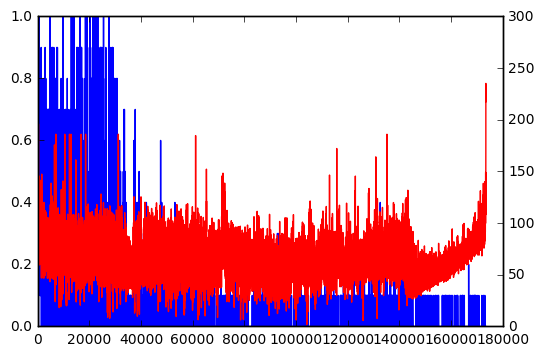

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import  MultipleLocator
temp2 = temp[(temp['label']!=-1)&(temp['voteMinus']!=0)].sort_values(by=['voteMinus'],ascending=False)
roll = temp2['label'].rolling(10, min_periods=1).mean()
dataR = temp2['scale'].rolling(10, min_periods=1).mean()
axL = plt.subplot(111)
axL.plot(range(len(roll)), roll.values, color='blue')
axR = axL.twinx()
axR.plot(range(len(roll)), dataR.values, color='red')
# xminorLocator = MultipleLocator(1)
# axL.xaxis.set_major_locator(xminorLocator)
plt.show()

In [ ]:
temp.head()

In [ ]:
plt.plot(range(len(ms)), ms.values)
plt.show()         